# lesson_2_DAN_CNN_Word2Vec_Embeddings_Classifier

**Description:** Text classification on the IMDB movie dataset using i) Deep Averaging Networks, and ii) Convolutions Neural Nets (CNN) and pre-trained Word2Vec word embeddings.<br>

Section 1 deals with setup and prerequisites, can does not deserve a lot of discussion. 
Data acquisition and preparation are handled in section 2, and section 3 looks at DANs and CNNs.

## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally. 

In [1]:
!pip install gensim==3.8.3 --quiet

In [2]:
!pip install tensorflow-datasets --quiet

In [3]:
!pip install -U tensorflow-text==2.8.2 --quiet

pydot is also required, along with **graphviz**.

In [4]:
!pip install pydot --quiet

Ready to do the imports.

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text


import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

import numpy as np

Below is a helper function to plot histories.

In [6]:
# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, history1, 
              history2, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=0.6,
              y_lim_accuracy_lower=0.7, 
              y_lim_accuracy_upper=0.8,
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)
    ax4.plot(history2.history['accuracy'])
    ax4.plot(history2.history['val_accuracy'])
    ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

Next, we get the word2vec model from nltk.

In [7]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/joachim.rahmfeld/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [8]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [9]:
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

How many words are in the vocabulary?

In [10]:
len(model.vocab)

43981

How do the word vectors look like? As expected:

In [11]:
model['great']

array([ 3.06035e-02,  8.86877e-02, -1.21269e-02,  7.61965e-02,
        5.66269e-02, -4.24702e-02,  4.10129e-02, -4.97567e-02,
       -3.64328e-03,  6.32889e-02, -1.42608e-02, -7.91111e-02,
        1.74877e-02, -3.83064e-02,  9.26433e-03,  2.95626e-02,
        7.70293e-02,  9.49334e-02, -4.28866e-02, -2.95626e-02,
        4.45244e-05,  6.82854e-02,  1.73836e-02,  3.14363e-02,
        6.53708e-02,  2.89380e-02, -4.39275e-02,  1.78000e-02,
        1.82164e-02, -4.70503e-02, -2.85216e-02,  1.79041e-02,
        1.06592e-01,  9.07696e-02,  6.78690e-02,  6.16755e-03,
       -2.08187e-02,  5.95936e-03,  1.51586e-03,  8.95205e-02,
        6.49544e-02, -3.12281e-02,  9.24351e-02, -2.45661e-02,
       -1.21269e-02, -1.53538e-03,  6.49544e-02, -1.12421e-02,
        9.10819e-03, -6.45380e-02,  4.43439e-02,  1.35738e-01,
       -7.91111e-02,  1.57181e-02, -4.72585e-02, -1.35322e-02,
       -4.33029e-02, -5.16304e-02,  1.37404e-01, -3.12281e-02,
       -6.49544e-02,  1.14087e-01, -6.41217e-02, -5.246

We can now build the embedding matrix and a vocabulary dictionary:

In [12]:
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

In [13]:
embedding_matrix

array([[ 0.0891758 ,  0.121832  , -0.0671959 , ..., -0.0480419 ,
        -0.0277889 ,  0.0872918 ],
       [ 0.0526281 ,  0.013157  , -0.010104  , ...,  0.0209349 ,
        -0.0537912 ,  0.0654217 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 , ..., -0.00832253,
        -0.00398034, -0.0825016 ],
       ...,
       [ 0.0887422 ,  0.0537124 ,  0.0467064 , ..., -0.0794009 ,
         0.0945805 , -0.0361975 ],
       [-0.011512  ,  0.0173624 , -0.0364862 , ..., -0.0425253 ,
         0.0231499 , -0.014217  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [14]:
train_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

In [15]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(30000)))
test_examples_batch, test_labels_batch = next(iter(test_data.batch(5000)))
#train_examples_batch

In [16]:
train_examples_batch[2:4]

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.',
       b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-c

In [17]:
train_labels_batch[2:4]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>

Next, we tokenize the data:

In [18]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples_batch)
test_tokens = tokenizer.tokenize(test_examples_batch)


Does this look right?

In [19]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

### 2.2 Data Preparation

For convenience, in this simple notebook we will define a maximum length and only keep the examples that are longer than that length.

In [20]:
MAX_SEQUENCE_LENGTH = 100

Next, we define a simple function that converts the tokens above into the appropriate word2vec index values.   

In [21]:
def sents_to_ids(token_list_list, label_list, num_examples=100000000):
    """
    converting a list of strings to a list of lists of word ids
    """
    text_ids = []
    text_labels = []
    example_count = 0
    use_token_list_list = token_list_list[:num_examples]
    for i, token_list in enumerate(use_token_list_list):
        if i < num_examples:
            try:
                example = []
                for token in list(token_list.numpy()):
                    decoded = token.decode('utf-8').replace('.','').replace(',','').replace('!','')
                    try:
                        example.append(vocab_dict[decoded])
                        
                    except:
                        example.append(43981)
                if len(example) >= MAX_SEQUENCE_LENGTH:
                    text_ids.append(example[:MAX_SEQUENCE_LENGTH])
                    text_labels.append(label_list[i])
                    if example_count % 5000 == 0:
                        print('Examples processed: ', example_count)
                    example_count += 1
                else:
                    pass
            except:
                pass

    
    print('Number of examples retained: ', example_count) 
    return (np.array(text_ids),   np.array(text_labels)) 

Now we can create training and test data that can be fed into the models of interest.

In [22]:
train_input, train_input_labels = sents_to_ids(train_tokens, train_labels_batch)
test_input, test_input_labels = sents_to_ids(test_tokens, test_labels_batch)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Number of examples retained:  17418
Examples processed:  0
Number of examples retained:  4329


Let's convince ourselves that the data looks correct:

In [23]:
train_input[:2]

array([[21531, 25272, 12291,  7427, 37254, 34710,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 38195, 23807, 42958,
        35058, 34177, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 26144,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 29168, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 38341, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511,  9337, 21807, 39168, 43981, 16856, 28070, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 34194, 12139, 12289, 39617, 36633,  9483,
        42958],
       [12139,  7841, 19666, 31757, 43981, 17853, 25745, 15445, 33741,
        19123, 35029, 16908, 21113, 21068, 43981, 43981,  5668, 43981,
        33456,  4942, 34554, 33013,  1200, 27498, 43981, 1880

In [24]:
train_input_labels[:2]

array([0, 0])

## 3. Modeling

### 3.1 DAN Model

Let us start by defining the embedding layer:

In [25]:
dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [26]:
dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

In [27]:
dan_embeddings = dan_embedding_layer(dan_input_layer)

In [28]:
dan_avg_input_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(dan_embeddings)

In [29]:
dan_hidden_out_1 = tf.keras.layers.Dense(100, activation='relu', name='hidden_1')(dan_avg_input_embeddings)
dan_hidden_out_1 = tf.keras.layers.Dropout(0.5)(dan_hidden_out_1)
dan_hidden_out_2 = tf.keras.layers.Dense(50, activation='relu', name='hidden_2')(dan_hidden_out_1)
dan_hidden_out_2 = tf.keras.layers.Dropout(0.5)(dan_hidden_out_2)

In [30]:
dan_classification = tf.keras.layers.Dense(1, 
                                           activation='sigmoid', 
                                           name='dan_classification')(dan_hidden_out_2)

In [31]:
dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])

In [32]:
dan_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
                 metrics='accuracy')

In [33]:
dan_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 hidden_1 (Dense)            (None, 100)               30100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden_2 (Dense)            (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0     

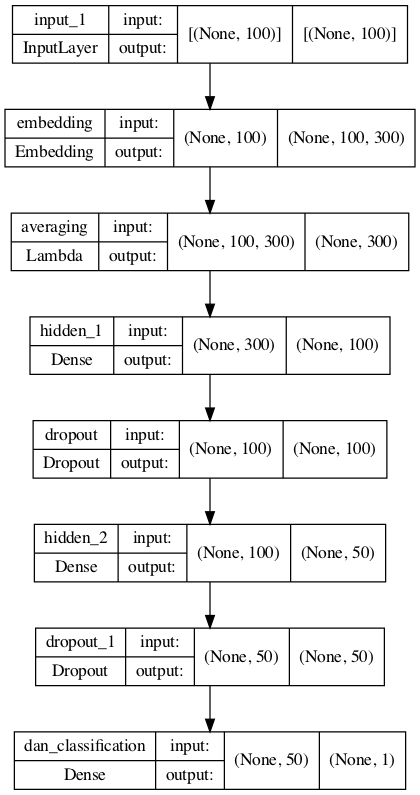

In [34]:
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

Let's look at the predictions and labels before training. Do those make sense?

In [35]:
print('predictions:\n', dan_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_input_labels[:5])

predictions:
 [[0.5086226 ]
 [0.5092812 ]
 [0.5063405 ]
 [0.50951713]
 [0.5069566 ]]


labels:
 [0 0 0 1 0]


In [36]:
dan_history = dan_model.fit(train_input,
                        train_input_labels,
                        validation_data=(test_input, test_input_labels),
                        batch_size=32,
                        epochs=20
             )

Epoch 1/20
545/545 [==============================] - 3s 4ms/step - loss: 0.6402 - accuracy: 0.6277 - val_loss: 0.5634 - val_accuracy: 0.7131
Epoch 2/20
545/545 [==============================] - 2s 3ms/step - loss: 0.5405 - accuracy: 0.7346 - val_loss: 0.5199 - val_accuracy: 0.7401
Epoch 3/20
545/545 [==============================] - 2s 3ms/step - loss: 0.5134 - accuracy: 0.7533 - val_loss: 0.5161 - val_accuracy: 0.7378
Epoch 4/20
545/545 [==============================] - 2s 3ms/step - loss: 0.5084 - accuracy: 0.7532 - val_loss: 0.5009 - val_accuracy: 0.7508
Epoch 5/20
545/545 [==============================] - 2s 3ms/step - loss: 0.4963 - accuracy: 0.7630 - val_loss: 0.4973 - val_accuracy: 0.7568
Epoch 6/20
545/545 [==============================] - 2s 3ms/step - loss: 0.4935 - accuracy: 0.7640 - val_loss: 0.4980 - val_accuracy: 0.7494
Epoch 7/20
545/545 [==============================] - 2s 3ms/step - loss: 0.4849 - accuracy: 0.7697 - val_loss: 0.4947 - val_accuracy: 0.7505
Epoch 

Let's revisit the predictions. How is this?

In [37]:
print('predictions:\n', dan_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_input_labels[:5])

predictions:
 [[0.01119411]
 [0.21241325]
 [0.6721447 ]
 [0.9706076 ]
 [0.5816388 ]]


labels:
 [0 0 0 1 0]


That is roughly as expected!


### 3.2. Averaging Network

Let us now compare to an Averaging Network ('an' below) that forgos the hidden layer(s). Otherwise it is the same architecture. Therefore, we can simply copy most of the steps.

In [38]:
an_embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)




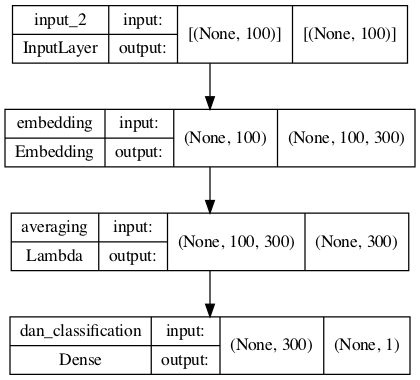

In [39]:
# layer construction

an_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

an_embeddings = dan_embedding_layer(an_input_layer)

an_avg_input_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(an_embeddings)

an_classification = tf.keras.layers.Dense(1, 
                                           activation='sigmoid', 
                                           name='dan_classification')(an_avg_input_embeddings)

# model definition

an_model = tf.keras.models.Model(inputs=an_input_layer, outputs=[an_classification])

an_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
                 metrics='accuracy')

# visualization of model

keras.utils.plot_model(an_model, show_shapes=True, dpi=90)

In [40]:
an_history = an_model.fit(train_input,
                        train_input_labels,
                        validation_data=(test_input, test_input_labels),
                        batch_size=32,
                        epochs=20
             )

Epoch 1/20
545/545 [==============================] - 2s 3ms/step - loss: 0.6873 - accuracy: 0.5785 - val_loss: 0.6832 - val_accuracy: 0.6140
Epoch 2/20
545/545 [==============================] - 1s 3ms/step - loss: 0.6767 - accuracy: 0.6472 - val_loss: 0.6746 - val_accuracy: 0.6433
Epoch 3/20
545/545 [==============================] - 1s 2ms/step - loss: 0.6674 - accuracy: 0.6619 - val_loss: 0.6670 - val_accuracy: 0.6549
Epoch 4/20
545/545 [==============================] - 1s 2ms/step - loss: 0.6592 - accuracy: 0.6741 - val_loss: 0.6602 - val_accuracy: 0.6586
Epoch 5/20
545/545 [==============================] - 1s 3ms/step - loss: 0.6515 - accuracy: 0.6772 - val_loss: 0.6546 - val_accuracy: 0.6588
Epoch 6/20
545/545 [==============================] - 1s 3ms/step - loss: 0.6448 - accuracy: 0.6794 - val_loss: 0.6487 - val_accuracy: 0.6681
Epoch 7/20
545/545 [==============================] - 1s 3ms/step - loss: 0.6386 - accuracy: 0.6866 - val_loss: 0.6429 - val_accuracy: 0.6713
Epoch 

### 3.3. Suggestions for Further Experiments and A Comparison

Here are some options for potential variations, some of which we may try in class:
* remove the hidden layers
* randomly initialize embedding matrix
* enable/disable retraining of embedding matrix
* vary dropout rates and dimensions
* compare some of the above for varying amounts of training data

All quite worth while...

Below is a sample plot for two different models:

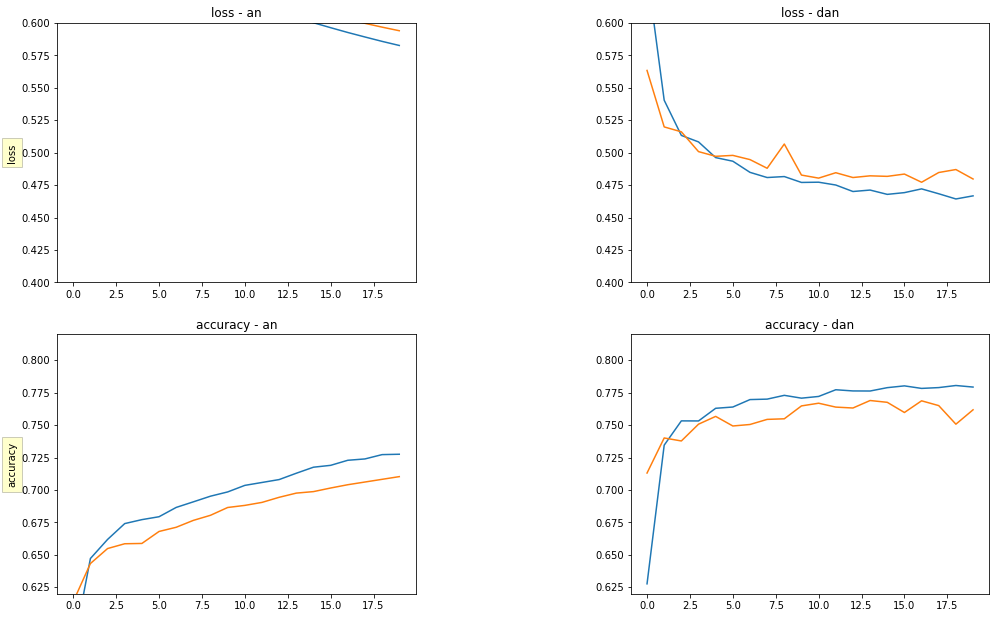

In [41]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          an_history, 
          dan_history, 
          model_1_name='an',
         model_2_name='dan',
         y_lim_accuracy_lower=0.62,
         y_lim_accuracy_upper=0.82)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Of course, the avergaing network is not done training.

### 3.4 CNN Model

In [42]:
cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [43]:
# Specify model hyperparameters.
epochs = 10
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 5, 10, 20]
dense_layer_dims = [100, 30]
dropout_rate = 0.5

In [44]:
cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

In [45]:
cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

h = cnn_embeddings

In [46]:
conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

In [47]:
h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

In [48]:
h = keras.layers.Dropout(rate=dropout_rate)(h)

In [49]:
for dense_layer_dim in dense_layer_dims:  
    h = keras.layers.Dense(dense_layer_dim, activation='relu')(h)

In [50]:
cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(h)

In [51]:
cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])

In [52]:
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 300)     13194600    ['input_3[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 98, 100)      90100       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 96, 100)      150100      ['embedding_2[0][0]']            
                                                                                            

The keras plot utility shows this probably a bit nicer:

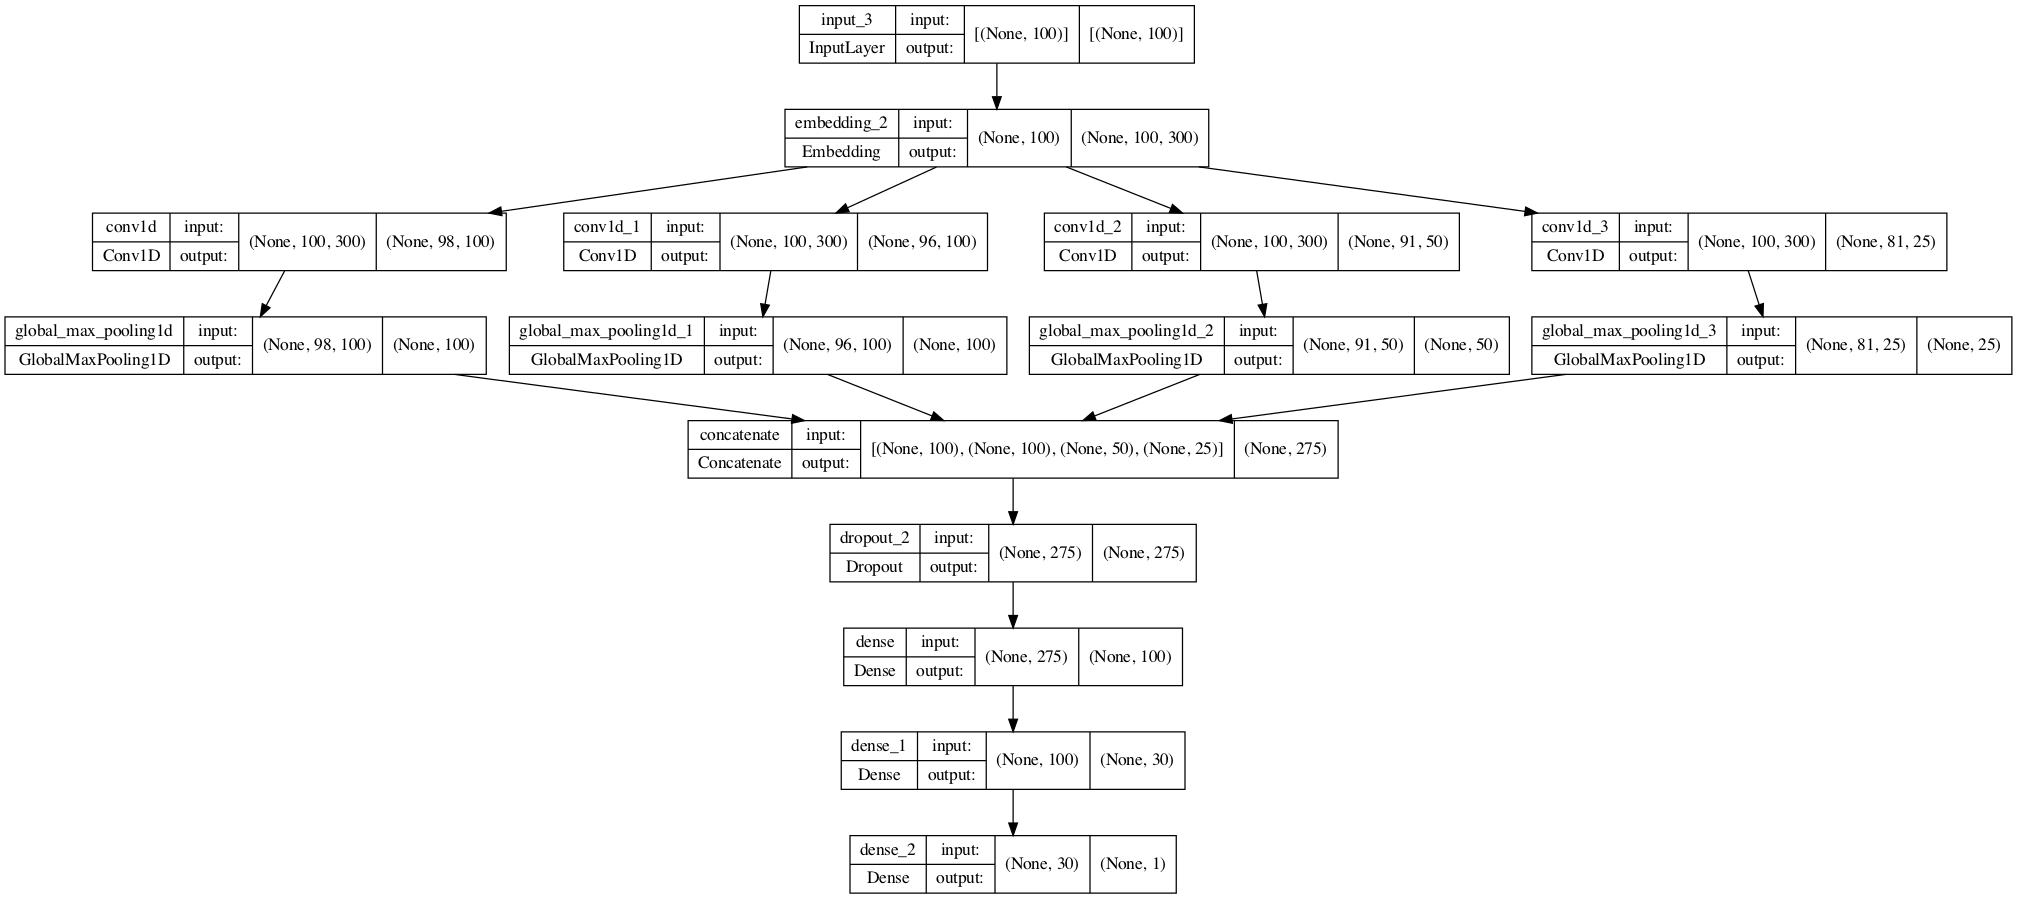

In [53]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

In [54]:
cnn_history = cnn_model.fit(train_input,
             np.array(train_input_labels),
             validation_data=(test_input, np.array(test_input_labels)),
             batch_size=32,
              epochs=5
             )

Epoch 1/5
545/545 [==============================] - 29s 51ms/step - loss: 0.5651 - accuracy: 0.6918 - val_loss: 0.4504 - val_accuracy: 0.7886
Epoch 2/5
545/545 [==============================] - 30s 54ms/step - loss: 0.4287 - accuracy: 0.8014 - val_loss: 0.4192 - val_accuracy: 0.8027
Epoch 3/5
545/545 [==============================] - 29s 54ms/step - loss: 0.3680 - accuracy: 0.8398 - val_loss: 0.4147 - val_accuracy: 0.8090
Epoch 4/5
545/545 [==============================] - 31s 57ms/step - loss: 0.2989 - accuracy: 0.8747 - val_loss: 0.4520 - val_accuracy: 0.7965
Epoch 5/5
545/545 [==============================] - 31s 57ms/step - loss: 0.2389 - accuracy: 0.9028 - val_loss: 0.4721 - val_accuracy: 0.8025


Again, a lot of things can be varied and compared. In addition to some of the items mentioned above, here we can also consider:
* number of filters 
* kernel sizes of filters
* number of convolutional structures

Below is a comparison of a CNN model with a DAN model: 

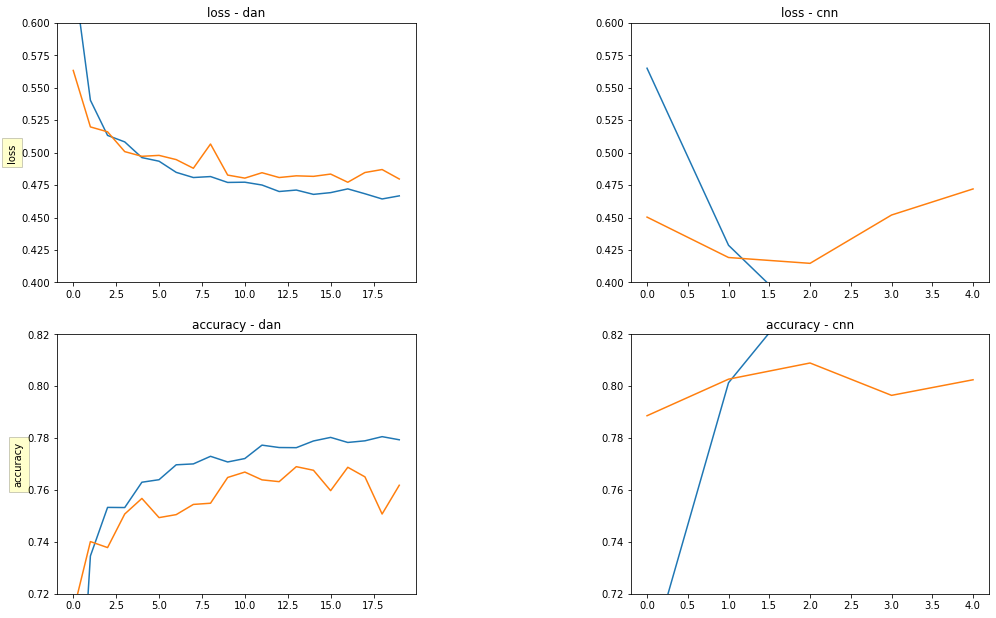

In [55]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_history, 
          cnn_history, 
          model_1_name='dan',
         model_2_name='cnn',
         y_lim_accuracy_lower=0.72,
         y_lim_accuracy_upper=0.82)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

You may want to check how the picture changes if you make the embeddings trainable...

This finalized the discussions of DANs and CNNs.

Over the next 2 weeks we will first add RNNs and then also classification with BERT.